# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
import numpy as np

In [2]:


torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

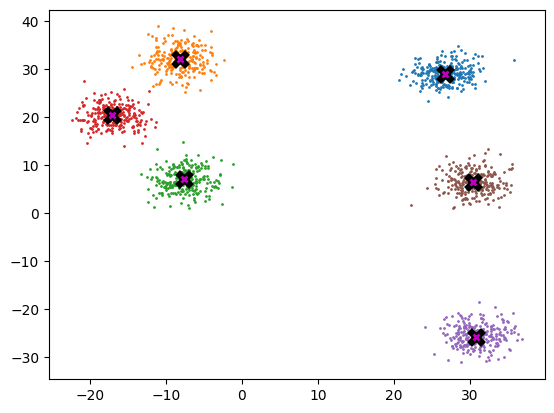

In [9]:
plot_data(centroids, data, n_samples)

# DBScan
Identify Core Points: For each point in the dataset, count the number of points within its eps neighborhood. If the count meets or exceeds MinPts, mark the point as a core point.
Form Clusters: For each core point that is not already assigned to a cluster, create a new cluster. Recursively find all density-connected points (points within the eps radius of the core point) and add them to the cluster.
Density Connectivity: Two points, a and b, are density-connected if there exists a chain of points where each point is within the eps radius of the next, and at least one point in the chain is a core point. This chaining process ensures that all points in a cluster are connected through a series of dense regions.
Label Noise Points: After processing all points, any point that does not belong to a cluster is labeled as noise.


In [11]:
X = data.clone()

In [12]:
sample_idx = torch.arange(len(X))
cluster_assignment = torch.zeros(len(X))
is_core_point = torch.zeros(len(X), dtype=bool)
is_neighbor =  torch.zeros((len(X), len(X)), dtype=bool)

eps = 4
min_pts = 3

In [13]:
def get_is_neighbor(x, X, eps):
    return torch.sqrt(((x-X)**2).sum(1)) <= eps

In [14]:
for i in range(X.shape[0]):
    is_neighbor = get_is_neighbor(X[i], X, eps)
    is_core_point[i] = is_neighbor.sum() >= min_pts

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML
import io
import base64
import tempfile
import os

class DBScan():
  def __init__(self, data, eps, min_pts):
    self.X = data.clone()
    self.eps = eps
    self.min_pts = min_pts
    self.cluster_assignment = torch.zeros(len(data))
    self.is_core_point = torch.zeros(len(data), dtype=bool)
    self.cluster = 0
    self.point_idx = torch.arange(len(data))

  def get_is_neighbor(self, x):
        return torch.sqrt(((x-self.X)**2).sum(1)) <= self.eps

  def convert_neighbors(self, target_point):
        # find unassigned neighbors
        is_neighbor = self.get_is_neighbor(target_point)
        is_unassigned = self.cluster_assignment == 0
        unassigned_neighbors = self.X[is_neighbor & is_unassigned]

        # if all neighbors are converted then return Nothing
        if unassigned_neighbors.shape[0]==0:
          return
        else:
          # if there are uncoverted neighbors then convert them and evangelize them to convert more
          # convert them!
          self.cluster_assignment[is_neighbor & is_unassigned] = self.cluster
          self.unassigned_core_points_idx = self.point_idx[self.is_core_point & (self.cluster_assignment == 0)]

          # print(f'{(is_neighbor & is_unassigned).sum()} new points found and added to cluster {self.cluster}!')
          # evanglize them!
          for neighbor in unassigned_neighbors:
            self.convert_neighbors(neighbor)

  def run_dbscan(self):
      self.fig, self.ax = plt.subplots()  # Create the figure and axes
      self.artists = []  # List to store artists for each frame

      # identify core points
      for i in range(self.X.shape[0]):
          is_neighbor = self.get_is_neighbor(self.X[i])
          self.is_core_point[i] = is_neighbor.sum() >= min_pts

      artists = self.plot_dbscan_data()  # Get the artists for the current frame
      self.artists.append(artists)  # Append the artists to the list

      self.core_points = self.X[self.is_core_point]
      self.unassigned_core_points_idx = self.point_idx[self.is_core_point & (self.cluster_assignment == 0)]

      # while there are unassigned core points
      while self.unassigned_core_points_idx.shape[0]>0:
        # take the next unassigned core point
        target_point_idx = self.unassigned_core_points_idx[0]
        target_point = self.X[target_point_idx]

        # convert it to the current cluster
        # print(f'Starting new cluster: {self.cluster}!')
        self.cluster += 1
        self.cluster_assignment[target_point_idx] = self.cluster

        artists = self.plot_dbscan_data()  # Get the artists for the current frame
        self.artists.append(artists)  # Append the artists to the list

        # convert its neighbors
        self.convert_neighbors(target_point)

        artists = self.plot_dbscan_data()  # Get the artists for the current frame
        self.artists.append(artists)  # Append the artists to the list


  def plot_dbscan_data(self):
      self.ax.set_prop_cycle(None)
      artists = [] # list to store the scatter plot collections
      for i in self.cluster_assignment.unique():
          samples = self.X[self.cluster_assignment == i]
          scatter = self.ax.scatter(samples[:, 0], samples[:, 1], s=1, label=f'Cluster {i}')
          self.ax.legend()
          artists.append(scatter)

      return artists

In [ ]:
from matplotlib.animation import ArtistAnimation, FuncAnimation
from IPython.display import HTML
eps = 2
min_points = 3

dbscan = DBScan(data, eps, min_pts)
dbscan.run_dbscan() # store the HTML object

In [23]:
animation = ArtistAnimation(dbscan.fig, dbscan.artists, interval=200, repeat=False)

In [24]:
from IPython.display import HTML
HTML(animation.to_jshtml())

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [11]:
midp = data.mean(0)
midp

tensor([ 9.235, 11.651])

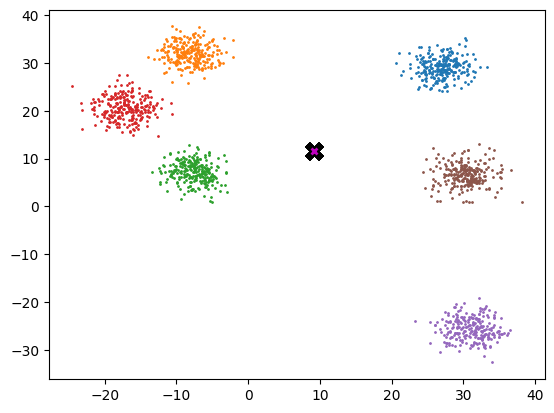

In [12]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [13]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [14]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

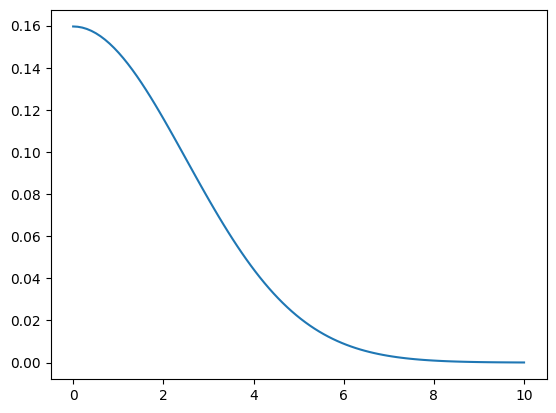

In [15]:
plot_func(partial(gaussian, bw=2.5))

In [16]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [17]:
def tri(d, i): return (-d+i).clamp_min(0)/i

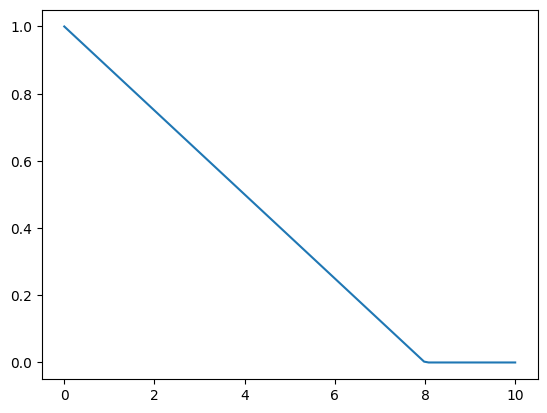

In [18]:
plot_func(partial(tri, i=8))

In [19]:
X = data.clone()
x = data[0]

In [20]:
x

tensor([28.975, 30.296])

In [21]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [22]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 3.733, -0.919],
        [ 4.491,  4.927],
        [ 3.239,  3.227],
        [ 2.154,  2.058],
        [ 1.199, -0.452],
        [ 1.869,  1.225],
        [ 3.434,  0.535]])

In [23]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 3.733, -0.919],
        [ 4.491,  4.927],
        [ 3.239,  3.227],
        [ 2.154,  2.058],
        [ 1.199, -0.452],
        [ 1.869,  1.225],
        [ 3.434,  0.535]])

In [24]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.844, 6.667, 4.572, 2.979, 1.281, 2.235, 3.476])

In [25]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.049,     0.005,  ...,     0.000,     0.000,     0.000])

In [26]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [27]:
weight[:,None].shape

torch.Size([1500, 1])

In [28]:
weight[:,None]*X

tensor([[    4.624,     4.835],
        [    1.235,     1.527],
        [    0.112,     0.116],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [29]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [30]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [31]:
%time X=meanshift(data)

CPU times: user 1.39 s, sys: 6.65 ms, total: 1.4 s
Wall time: 1.48 s


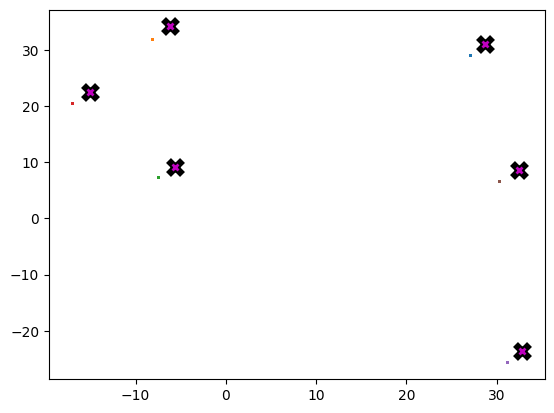

In [32]:
plot_data(centroids+2, X, n_samples)

## Animation

In [33]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [34]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [35]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [36]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [37]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [38]:
dist_b(X, x)

tensor([[ 0.000,  3.844,  6.667,  ..., 29.271, 25.056, 25.046],
        [ 3.844,  0.000,  5.895,  ..., 30.594, 26.296, 26.368],
        [ 6.667,  5.895,  0.000,  ..., 25.019, 20.707, 20.827],
        [ 4.572,  4.175,  2.112,  ..., 26.425, 22.124, 22.202],
        [ 2.979,  3.370,  3.701,  ..., 27.413, 23.134, 23.180]])

In [39]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [40]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [41]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.031,     0.001,  ...,     0.000,     0.000,     0.000],
        [    0.031,     0.199,     0.003,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.003,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.015,     0.023,     0.114,  ...,     0.000,     0.000,     0.000],
        [    0.066,     0.048,     0.036,  ...,     0.000,     0.000,     0.000]])

In [42]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [43]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [44]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [45]:
num

tensor([[489.810, 518.227],
        [369.022, 426.363],
        [201.638, 212.026],
        [450.912, 479.514],
        [603.849, 642.769]])

In [46]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[489.810, 518.227],
        [369.022, 426.363],
        [201.638, 212.026],
        [450.912, 479.514],
        [603.849, 642.769]])

In [47]:
weight@X

tensor([[489.810, 518.227],
        [369.022, 426.363],
        [201.638, 212.026],
        [450.912, 479.514],
        [603.849, 642.769]])

In [48]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [49]:
num/div

tensor([[28.101, 29.732],
        [26.093, 30.148],
        [25.613, 26.933],
        [26.282, 27.949],
        [26.893, 28.626]])

In [50]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [51]:
data = data.cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [52]:
X = meanshift(data).cpu()

In [53]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

648 ms ± 89.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


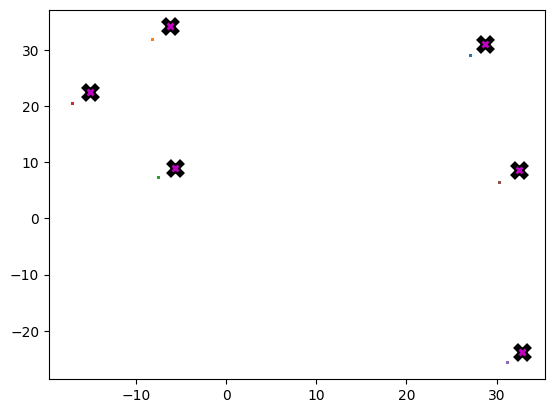

In [54]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

In [54]:

V

In [57]:
X = data.clone()

In [58]:
X[0]


tensor([28.975, 30.296])

AttributeError: 'builtin_function_or_method' object has no attribute 'arange'